# 7.0 - Expected Pitch Effectiveness
Modeling expected pitch effectiveness based on situation (count, handedness, etc) to understand pitch usage and performance.

## Libraries

In [1]:
import logging
import sys
import warnings

import os

import pandas as pd
import numpy as np

from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)

from yellowbrick.classifier import (
    ClassificationReport,
    ROCAUC,
    ClassPredictionError,
    DiscriminationThreshold
)

## Setup

In [2]:
# Supress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# BQ Logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [4]:
# BigQuery
PROJECT_ID = 'ad-fantasy-baseball'
CREDENTIALS_PATH = os.path.join(os.pardir, './credentials/mlb-db-analysis-user.json')

In [5]:
# Pandas
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [6]:
# Seaborn
sns.set(rc={'figure.figsize': (16, 9)})

## Data

In [7]:
params = {
    'min_year': 2016
}

In [8]:
SQL = \
"""
SELECT
  t_event.*,
  t_player.mlb_name AS pitcher_name
FROM
  (
    SELECT
      event_id,
      MAX(game_year) AS game_year,
      MAX(pitcher) AS pitcher_id,
      MAX(p_throws) AS pitcher_hand,
      MAX(stand) AS batter_hand,
      MAX(balls) AS balls,
      MAX(strikes) AS strikes,
      CONCAT(CAST(MAX(balls) AS STRING), '-', CAST(MAX(strikes) AS STRING)) AS count,
      MAX(pitch_type) AS pitch_type,
      MAX(description) AS description,
      MAX(events) AS events,
      MAX(estimated_woba_using_speedangle) AS estimated_woba_using_speedangle,
      MAX(woba_value) AS woba_value,
      MAX(woba_denom) AS woba_denom
    FROM
      `ad-fantasy-baseball.core.statcast_extended`
    WHERE
      game_year >= {min_year}
        AND description NOT IN (
          'foul_bunt',
          'hit_by_pitch',
          'intent_ball',
          'missed_bunt',
          'pitchout',
          'bunt_foul_tip',
          'swinging_pitchout',
          'foul_pitchout',
          'pitchout_hit_into_play',
          'pitchout_hit_into_play_score'
        )
    GROUP BY 1
  ) t_event
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `ad-fantasy-baseball.core.players`
  ) t_player
    ON (t_event.pitcher_id = t_player.mlb_id)
"""

In [9]:
sql_base = SQL.format(**params)
df_base = read_gbq(
    query=sql_base,
    dialect='standard',
    project_id=PROJECT_ID,
    private_key=CREDENTIALS_PATH,
    configuration={'query': {'useQueryCache': False}}
)

df_copy = df_base.copy()

Requesting query... 
ok.
Query running...
Job ID: e2408adc-376c-43c1-89cd-8e31670b4ece
Query running...
  Elapsed 8.91 s. Waiting...
  Elapsed 9.93 s. Waiting...
  Elapsed 10.96 s. Waiting...
  Elapsed 13.49 s. Waiting...
  Elapsed 14.54 s. Waiting...
  Elapsed 15.57 s. Waiting...
  Elapsed 16.59 s. Waiting...
  Elapsed 17.61 s. Waiting...
  Elapsed 18.64 s. Waiting...
  Elapsed 19.66 s. Waiting...
Got 2533662 rows.

Total time taken 387.39 s.
Finished at 2019-06-16 18:58:10.


In [10]:
df_base.head()

,event_id,game_year,pitcher_id,pitcher_hand,batter_hand,balls,strikes,count,pitch_type,description,events,estimated_woba_using_speedangle,woba_value,woba_denom,pitcher_name
0,529872.28.7,2018,612434,R,R,4,2,4-2,SI,foul,None,None,None,None,Miguel Castro
1,530969.66.11,2018,502327,L,R,4,2,4-2,SI,foul,None,None,None,None,Hector Santiago
2,491781.45.9,2017,572971,L,R,4,2,4-2,FT,ball,walk,None,0.7,1,Dallas Keuchel
3,530969.66.7,2018,502327,L,R,4,2,4-2,SI,foul,None,None,None,None,Hector Santiago
4,529872.28.8,2018,612434,R,R,4,2,4-2,SI,swinging_strike,strikeout_double_play,None,0,1,Miguel Castro


## Data prep

In [11]:
# Remove bad data
df_base = df_base[df_base['balls'] < 4]
df_base = df_base[df_base['strikes'] < 3]

In [12]:
# Data formatting
numeric_cols = [
    'balls',
    'strikes',
    'estimated_woba_using_speedangle',
    'woba_value',
    'woba_denom'
]

df_base[numeric_cols] = df_base[numeric_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [13]:
# Outcome filters
outcomes_strike = [
    'called_strike',
    'swinging_strike',
    'swinging_strike_blocked',
    'missed_bunt'
]
outcomes_swinging_strike = [
    'swinging_strike',
    'swinging_strike_blocked',
    'missed_bunt'
]
outcomes_ball = [
    'ball',
    'blocked_ball',
    'pitchout',
    'hit_by_pitch'
]
outcomes_contact = [
    'hit_into_play',
    'hit_into_play_no_out',
    'hit_into_play_score',
    'foul',
    'foul_tip',
    'foul_bunt'
]
outcomes_swing = [
    'swinging_strike',
    'swinging_strike_blocked',
    'hit_into_play',
    'hit_into_play_no_out',
    'hit_into_play_score',
    'foul',
    'foul_tip'
]

_pitcher_r = df_base['pitcher_hand'] == 'R'
_batter_r = df_base['batter_hand'] == 'R'
_strike = df_base['description'].isin(outcomes_strike)
_ball = df_base['description'].isin(outcomes_ball)
_contact = df_base['description'].isin(outcomes_contact)
_swing = df_base['description'].isin(outcomes_swing)

In [14]:
df_base['flag_strike'] = np.where(df_base['description'].isin(outcomes_strike), 1, 0)
df_base['flag_contact'] = np.where(df_base['description'].isin(outcomes_contact), 1, 0)
df_base['flag_swstr'] = np.where(df_base['description'].isin(outcomes_swinging_strike), 1, 0)
df_base['flag_cstr'] = np.where(df_base['description'] == 'called_strike', 1, 0)

df_base['flag_00'] = np.where(df_base['count'] == '0-0', 1, 0)
df_base['flag_01'] = np.where(df_base['count'] == '0-1', 1, 0)
df_base['flag_02'] = np.where(df_base['count'] == '0-2', 1, 0)
df_base['flag_10'] = np.where(df_base['count'] == '1-0', 1, 0)
df_base['flag_11'] = np.where(df_base['count'] == '1-1', 1, 0)
df_base['flag_12'] = np.where(df_base['count'] == '1-2', 1, 0)
df_base['flag_20'] = np.where(df_base['count'] == '2-0', 1, 0)
df_base['flag_21'] = np.where(df_base['count'] == '2-1', 1, 0)
df_base['flag_22'] = np.where(df_base['count'] == '2-2', 1, 0)
df_base['flag_30'] = np.where(df_base['count'] == '3-0', 1, 0)
df_base['flag_31'] = np.where(df_base['count'] == '3-1', 1, 0)
df_base['flag_32'] = np.where(df_base['count'] == '3-2', 1, 0)

df_base['flag_platoon'] = np.where(df_base['pitcher_hand'] == df_base['batter_hand'], 1, 0)

In [15]:
df_base.head()

,event_id,game_year,pitcher_id,pitcher_hand,batter_hand,balls,strikes,count,pitch_type,description,events,estimated_woba_using_speedangle,woba_value,woba_denom,pitcher_name,flag_strike,flag_contact,flag_swstr,flag_cstr,flag_00,flag_01,flag_02,flag_10,flag_11,flag_12,flag_20,flag_21,flag_22,flag_30,flag_31,flag_32,flag_platoon
11,491141.59.1,2017,543883,R,L,0,0,0-0,FC,foul,None,NaN,NaN,NaN,Nick Vincent,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
12,490652.31.1,2017,543901,R,L,0,0,0-0,CU,called_strike,None,NaN,NaN,NaN,Ryan Weber,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
13,506415.2.1,2017,543903,R,L,0,0,0-0,FF,ball,None,NaN,NaN,NaN,Allen Webster,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
14,448038.61.1,2016,543935,R,R,0,0,0-0,FF,called_strike,None,NaN,NaN,NaN,Alex Wilson,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
15,490895.68.1,2017,543935,R,L,0,0,0-0,FF,ball,None,NaN,NaN,NaN,Alex Wilson,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Modeling

In [16]:
def train_and_evaluate_model(
        df,
        label,
        features,
        model,
        test_size=0.15,
        decision_threshold=0.5,
        discrimination_plot=False
    ):
    
    # Train model
    y = df[label]
    X = df[features]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred_proba = [ y[1] for y in model.predict_proba(X_test) ]
    y_pred = [ 1 if y > decision_threshold else 0 for y in y_pred_proba]
    
    # Model description
    model_name = type(model).__name__
    
    if model_name in ['LogisticRegression']:
        print('MODEL COEFFICIENTS FOR {:s} MODEL'.format(model_name))
        
        intercept = model.intercept_[0]
        if intercept > 0:
            print("{:30}[{:5.3f}]".format('Intercept:', intercept))
        
        for feature, weight in list(zip(features, model.coef_[0])):
            print("{:30}[{:5.4f}]".format(feature + ":", weight))
        print('\n')
                
    # Model metrics
    prs = precision_score(y_test, y_pred)
    res = recall_score(y_test, y_pred)
    acs = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print('MODEL METRICS FOR {:s} MODEL'.format(model_name))
    print('Precision Score: {:5.4f}'.format(prs))
    print('Recall Score: {:5.4f}'.format(res))
    print('Accuracy Score: {:5.4f}'.format(acs))
    print('F1 Score: {:5.4f}'.format(f1))
    
    print('\nCONFUSION MATRIC FOR {:s} MODEL'.format(model_name))
    print(confusion_matrix(y_test, y_pred))
    
    # Classification Report
    class_report = ClassificationReport(model)
    class_report.fit(X_train, y_train)
    class_report.score(X_test, y_test)
    class_report.poof()

    # ROC AUC
    rocauc = ROCAUC(model)
    rocauc.fit(X_train, y_train)
    rocauc.score(X_test, y_test)
    rocauc.poof()
    
    # Class Prediction Error Report
    cpe_report = ClassPredictionError(model)
    cpe_report.fit(X_train, y_train)
    cpe_report.score(X_test, y_test)
    cpe_report.poof()
    
    # Discrimination Threshold Curve
    if discrimination_plot:
        dt_curve = DiscriminationThreshold(model)
        dt_curve.fit(X_train, y_train)
        dt_curve.poof()

### Predicting swinging strike percentage

MODEL COEFFICIENTS FOR LogisticRegression MODEL
flag_00:                      [-0.5493]
flag_01:                      [0.0857]
flag_02:                      [0.2362]
flag_10:                      [-0.1758]
flag_11:                      [0.1299]
flag_12:                      [0.2900]
flag_20:                      [-0.3211]
flag_21:                      [0.1009]
flag_22:                      [0.2522]
flag_30:                      [-2.0794]
flag_31:                      [-0.2098]
flag_32:                      [0.0997]
flag_platoon:                 [0.1266]


MODEL METRICS FOR LogisticRegression MODEL
Precision Score: 0.1254
Recall Score: 0.7390
Accuracy Score: 0.4306
F1 Score: 0.2144

CONFUSION MATRIC FOR LogisticRegression MODEL
[[134128 205967]
 [ 10429  29524]]


/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


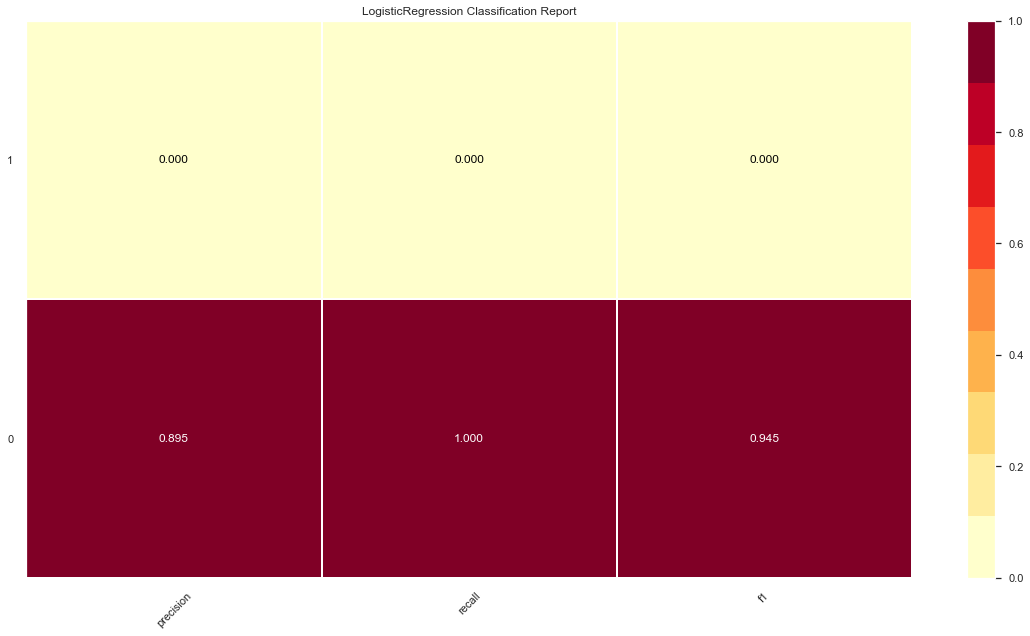

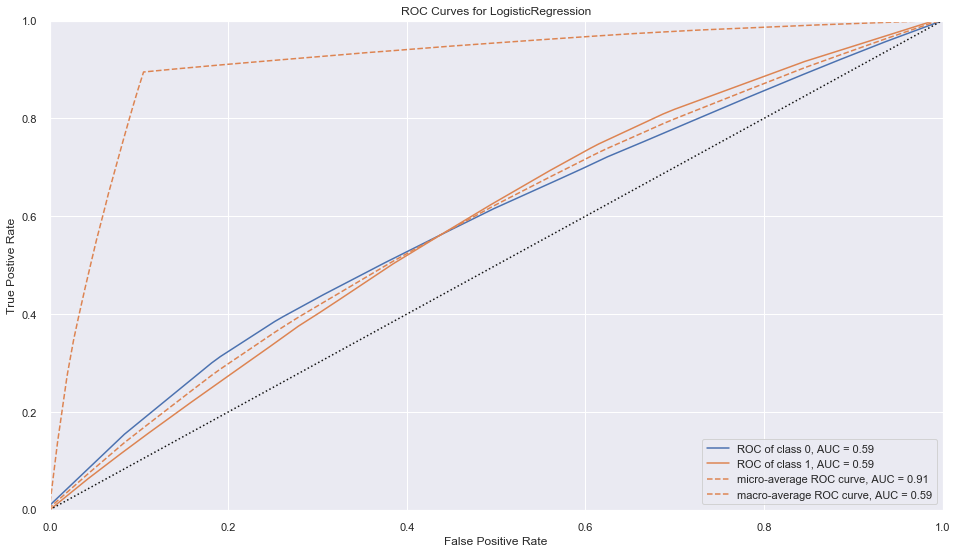

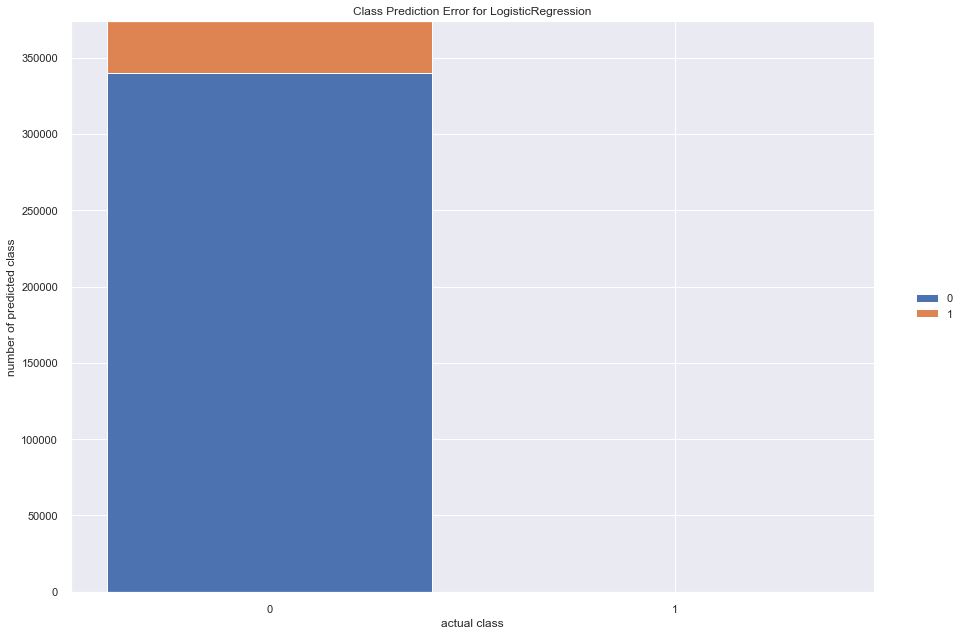

In [17]:
df_swstr = df_base.copy()

swstr_label = 'flag_swstr'
swstr_classes = ['contact', 'swinging_strike']
swstr_features = [
    'flag_00',
    'flag_01',
    'flag_02',
    'flag_10',
    'flag_11',
    'flag_12',
    'flag_20',
    'flag_21',
    'flag_22',
    'flag_30',
    'flag_31',
    'flag_32',
    'flag_platoon'
]
swstr_model = LogisticRegression(
    fit_intercept=True
)

train_and_evaluate_model(
    df=df_swstr,
    label=swstr_label,
    features=swstr_features,
    model=swstr_model,
    decision_threshold=0.1
)

In [87]:
# # Predict specific situations
# for hand in range(0, 2):
#     for feature in range(0, 12):
#         weights = np.zeros(12)
#         weights[feature] = 1
#         weights = np.append(weights, hand)

#         print(weights)
#         print(swstr_model.predict_proba(X=[weights]))

### Predicting whiff-per-swing percentage

MODEL COEFFICIENTS FOR LogisticRegression MODEL
flag_00:                      [0.0519]
flag_01:                      [0.1381]
flag_02:                      [0.2063]
flag_10:                      [-0.0060]
flag_11:                      [0.0274]
flag_12:                      [0.1070]
flag_20:                      [-0.2326]
flag_21:                      [-0.1294]
flag_22:                      [-0.0878]
flag_30:                      [-0.5253]
flag_31:                      [-0.4297]
flag_32:                      [-0.3944]
flag_platoon:                 [0.1125]


MODEL METRICS FOR LogisticRegression MODEL
Precision Score: 0.2534
Recall Score: 0.5444
Accuracy Score: 0.5311
F1 Score: 0.3458

CONFUSION MATRIC FOR LogisticRegression MODEL
[[72385 64917]
 [18436 22030]]


/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


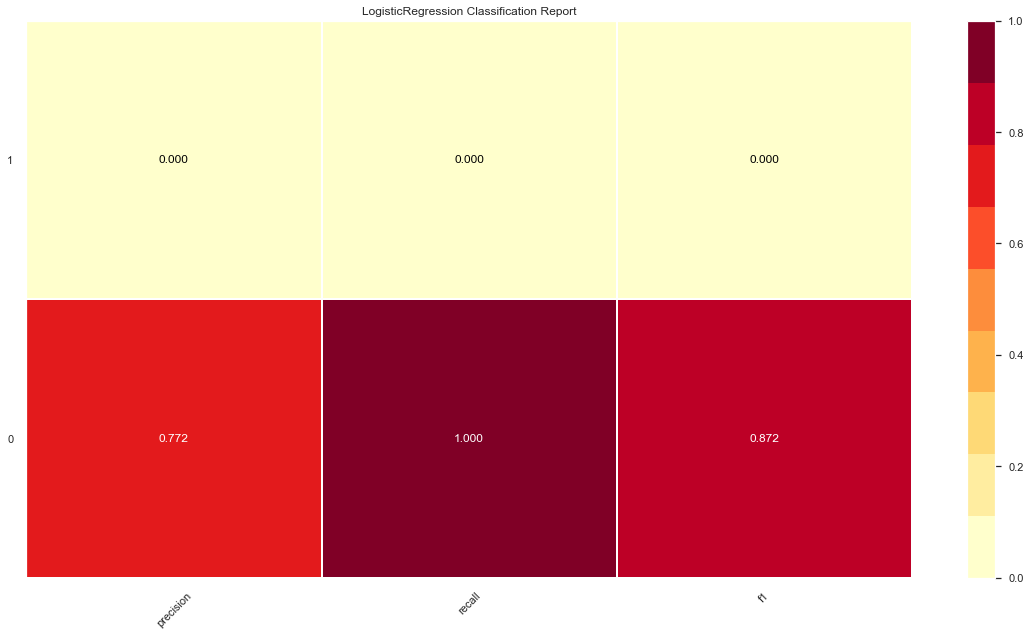

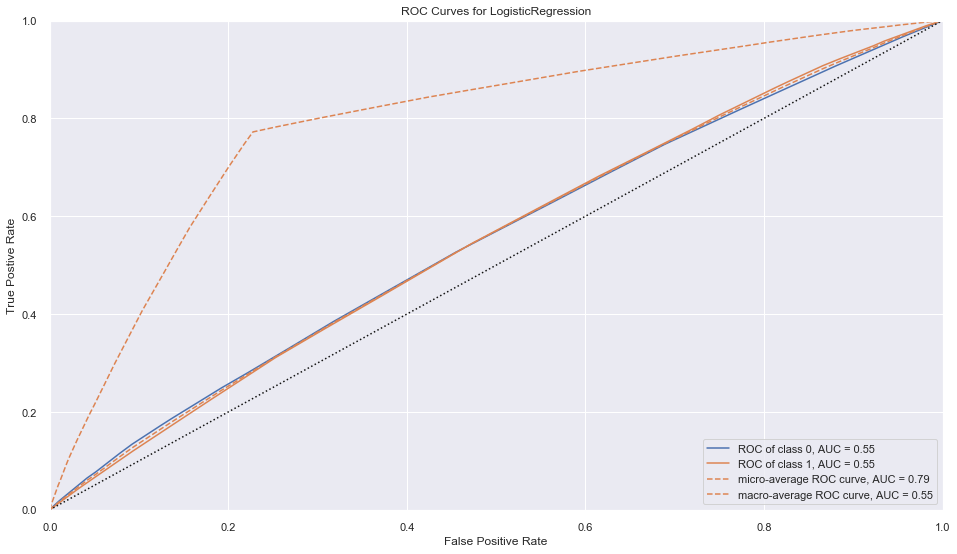

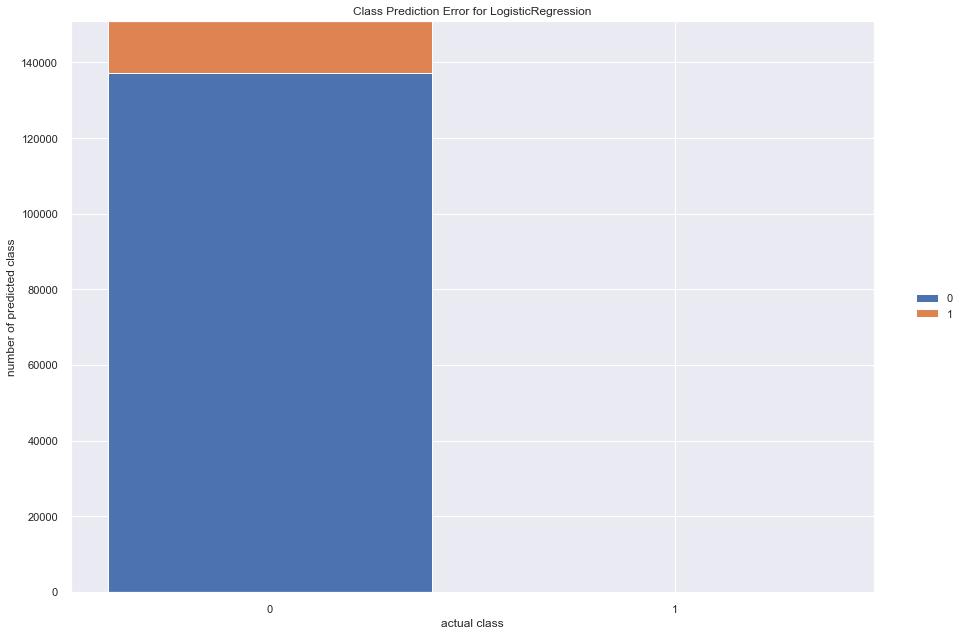

In [47]:
df_whiff = df_base[_swing].copy()

whiff_label = 'flag_swstr'
whiff_classes = ['contact', 'swinging_strike']
whiff_features = [
    'flag_00',
    'flag_01',
    'flag_02',
    'flag_10',
    'flag_11',
    'flag_12',
    'flag_20',
    'flag_21',
    'flag_22',
    'flag_30',
    'flag_31',
    'flag_32',
    'flag_platoon'
]
whiff_model = LogisticRegression(
    fit_intercept=True
)

train_and_evaluate_model(
    df=df_whiff,
    label=whiff_label,
    features=whiff_features,
    model=whiff_model,
    decision_threshold=0.23
)

In [88]:
# # Predict specific situations
# for hand in range(0, 2):
#     for feature in range(0, 12):
#         weights = np.zeros(12)
#         weights[feature] = 1
#         weights = np.append(weights, hand)

#         print(weights)
#         print(whiff_model.predict_proba(X=[weights]))

## Analysis

In [20]:
# Apply model(s) to pitch-level data
df_pred_swstr = df_swstr[swstr_features]

df_swstr['pred_swstr'] = [ pred[1] for pred in swstr_model.predict_proba(X=df_pred_swstr)]

#### Since 2016

In [21]:
df_summary_swstr = df_swstr.groupby(['pitcher_id', 'pitcher_name', 'pitch_type']).agg({
    'event_id': 'count',
    'flag_swstr': 'mean',
    'pred_swstr': 'mean'
}).rename(columns={
    'event_id': 'pitches',
    'flag_swstr': 'swstr'
})

df_summary_swstr['delta_swstr'] = df_summary_swstr['swstr'] - df_summary_swstr['pred_swstr']

In [22]:
df_summary_swstr[df_summary_swstr['pitches'] > 100]\
    .sort_values(by=['pred_swstr'], ascending=False)\
    .head(10)

,,,pitches,swstr,pred_swstr,delta_swstr
pitcher_id,pitcher_name,pitch_type,,,,
448306,James Shields,EP,205,0.190244,0.137834,0.052410
476454,Dellin Betances,SL,394,0.203046,0.137708,0.065338
434671,Anibal Sanchez,CH,242,0.206612,0.131870,0.074741
657610,Trevor Hildenberger,FF,149,0.080537,0.131845,-0.051308
518553,Steve Cishek,FF,255,0.172549,0.131761,0.040788
467100,Ivan Nova,FC,143,0.195804,0.131631,0.064173
607192,Tyler Glasnow,SL,172,0.261628,0.131511,0.130117
545333,Trevor Bauer,SL,636,0.209119,0.131342,0.077777
445276,Kenley Jansen,SL,296,0.229730,0.129716,0.100014


In [30]:
# Summary filters
_cutoff_swstr = df_summary_swstr['pitches'] > 500

df_summary_swstr_f = df_summary_swstr[_cutoff_swstr]

Text(0.5,1,'SwStr % over expectation as a function of predicted SwStr %, since 2016')

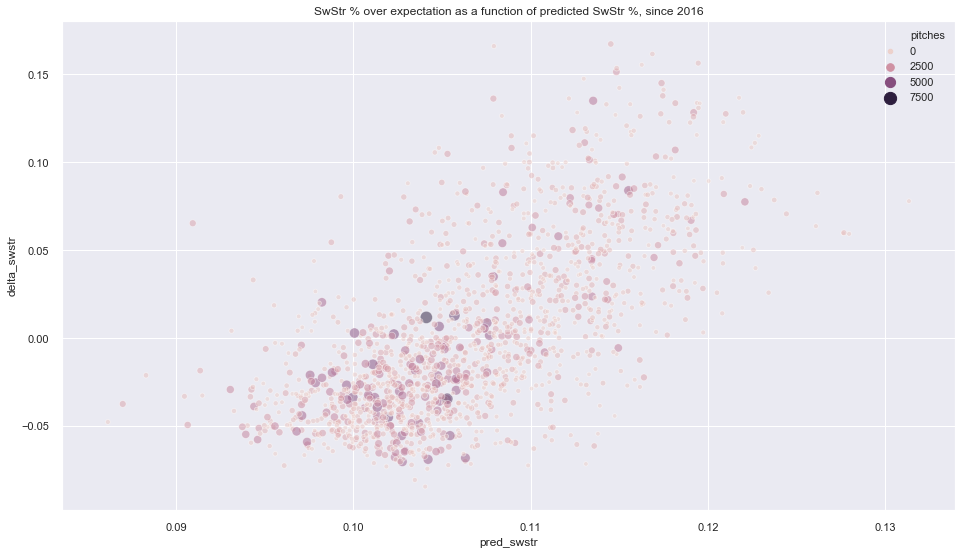

In [31]:
sns.scatterplot(
    x=df_summary_swstr_f['pred_swstr'],
    y=df_summary_swstr_f['delta_swstr'],
    hue=df_summary_swstr_f['pitches'],
    size=df_summary_swstr_f['pitches'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('SwStr % over expectation as a function of predicted SwStr %, since 2016')

Text(0.5,1,'SwStr % over expectation as a function of pitch count, since 2016')

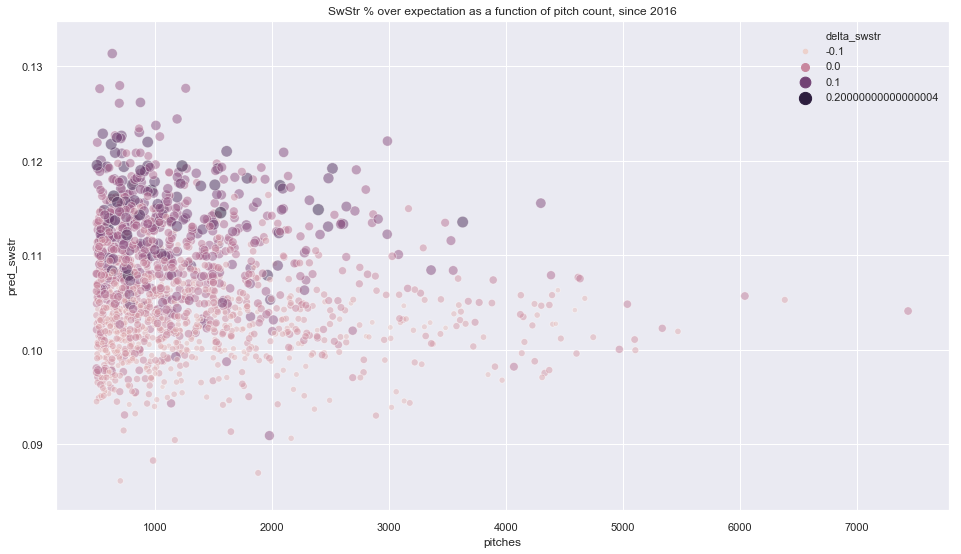

In [32]:
sns.scatterplot(
    x=df_summary_swstr_f['pitches'],
    y=df_summary_swstr_f['pred_swstr'],
    hue=df_summary_swstr_f['delta_swstr'],
    size=df_summary_swstr_f['delta_swstr'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('SwStr % over expectation as a function of pitch count, since 2016')

#### Pitches in 2019

In [35]:
df_swstr_2019 = df_swstr[df_swstr['game_year'] == 2019].groupby(['pitcher_id', 'pitcher_name', 'pitch_type']).agg({
    'event_id': 'count',
    'flag_swstr': 'mean',
    'pred_swstr': 'mean'
}).rename(columns={
    'event_id': 'pitches',
    'flag_swstr': 'swstr'
})

df_swstr_2019['delta_swstr'] = df_swstr_2019['swstr'] - df_swstr_2019['pred_swstr']

In [37]:
df_swstr_2019[df_swstr_2019['pitches'] > 50].sort_values(by=['swstr'], ascending=False).head(10)

,,,pitches,swstr,pred_swstr,delta_swstr
pitcher_id,pitcher_name,pitch_type,,,,
663432,Tanner Rainey,SL,62,0.370968,0.113783,0.257185
669203,Corbin Burnes,SL,192,0.369792,0.119103,0.250688
628452,Raisel Iglesias,CH,107,0.327103,0.120242,0.206860
596112,Robert Stephenson,SL,214,0.322430,0.110527,0.211903
571760,Andrew Heaney,CU,108,0.305556,0.121846,0.183710
592454,Tommy Kahnle,CH,189,0.296296,0.113869,0.182427
608648,Tyler Duffey,SL,78,0.294872,0.127209,0.167662
623352,Josh Hader,SL,51,0.294118,0.125274,0.168843
572362,Robbie Erlin,CH,82,0.292683,0.115298,0.177385


In [40]:
# Summary filters
_cutoff_year_swstr = df_swstr_2019['pitches'] > 50

df_swstr_2019_f = df_swstr_2019[_cutoff_year_swstr]

Text(0.5,1,'SwStr % over expectation as a function of predicted SwStr %, 2019')

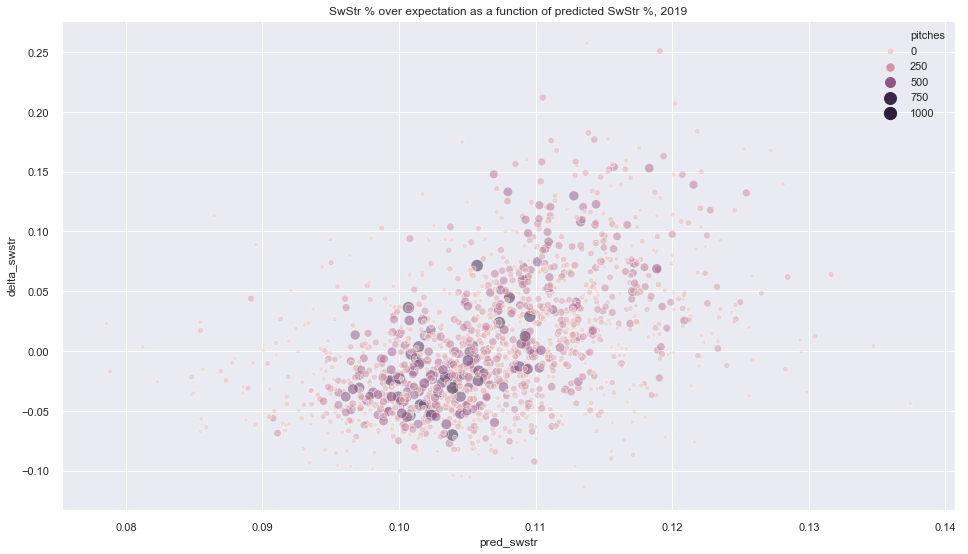

In [41]:
sns.scatterplot(
    x=df_swstr_2019_f['pred_swstr'],
    y=df_swstr_2019_f['delta_swstr'],
    hue=df_swstr_2019_f['pitches'],
    size=df_swstr_2019_f['pitches'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('SwStr % over expectation as a function of predicted SwStr %, 2019')

Text(0.5,1,'SwStr % over expectation as a function of pitch count, 2019')

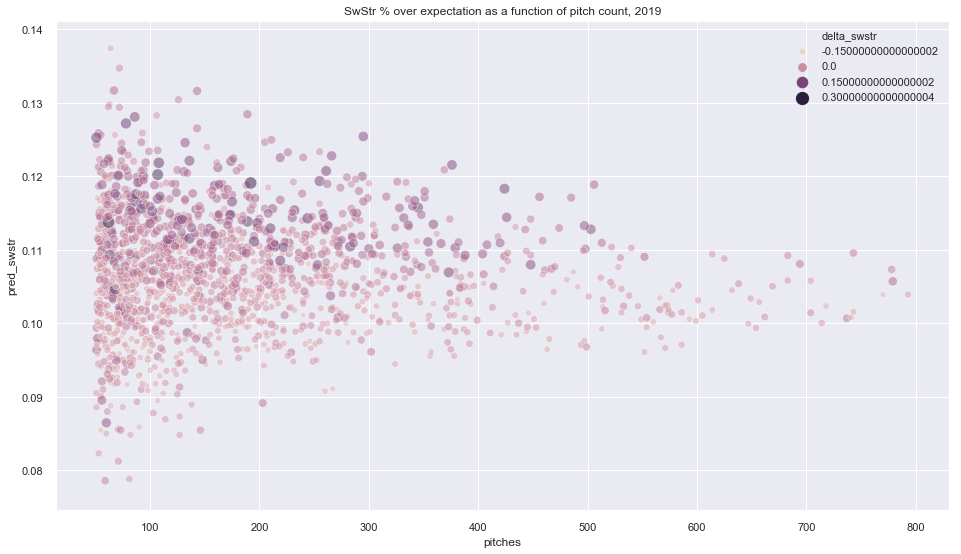

In [42]:
sns.scatterplot(
    x=df_swstr_2019_f['pitches'],
    y=df_swstr_2019_f['pred_swstr'],
    hue=df_swstr_2019_f['delta_swstr'],
    size=df_swstr_2019_f['delta_swstr'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('SwStr % over expectation as a function of pitch count, 2019')

#### Export data

In [43]:
df_swstr_2019.to_csv('~/Desktop/expected_swstr_2019.csv')
df_summary_swstr.to_csv('~/Desktop/expected_swstr_all_time.csv')

### Whiff-per-swing percentage

In [48]:
# Apply model(s) to pitch-level data
df_pred_whiff = df_whiff[whiff_features]

df_whiff['pred_whiff'] = [ pred[1] for pred in whiff_model.predict_proba(X=df_pred_whiff)]

#### Since 2016

In [50]:
df_summary_whiff = df_whiff.groupby(['pitcher_id', 'pitcher_name', 'pitch_type']).agg({
    'event_id': 'count',
    'flag_swstr': 'mean',
    'pred_whiff': 'mean'
}).rename(columns={
    'event_id': 'pitches',
    'flag_swstr': 'whiff'
})

df_summary_whiff['delta_whiff'] = df_summary_whiff['whiff'] - df_summary_whiff['pred_whiff']

In [51]:
df_summary_whiff[df_summary_whiff['pitches'] > 100]\
    .sort_values(by=['pred_whiff'], ascending=False)\
    .head(10)

,,,pitches,whiff,pred_whiff,delta_whiff
pitcher_id,pitcher_name,pitch_type,,,,
448306,James Shields,EP,113,0.345133,0.251445,0.093688
446899,Brad Ziegler,CU,255,0.388235,0.249510,0.138726
516969,Kelvin Herrera,SL,209,0.430622,0.248741,0.181881
643256,Adam Cimber,SL,159,0.270440,0.248352,0.022088
518560,Paul Clemens,CU,146,0.232877,0.247784,-0.014907
445276,Kenley Jansen,SL,145,0.468966,0.247665,0.221300
453265,Tony Watson,SL,249,0.349398,0.247596,0.101802
622554,Seranthony Dominguez,SL,200,0.460000,0.247503,0.212497
519096,Dan Otero,SL,126,0.253968,0.247184,0.006784


In [65]:
# Summary filters
_cutoff_whiff = df_summary_whiff['pitches'] > 250

df_summary_whiff_f = df_summary_whiff[_cutoff_whiff]

Text(0.5,1,'Whiff % over expectation as a function of predicted Whiff %, since 2016')

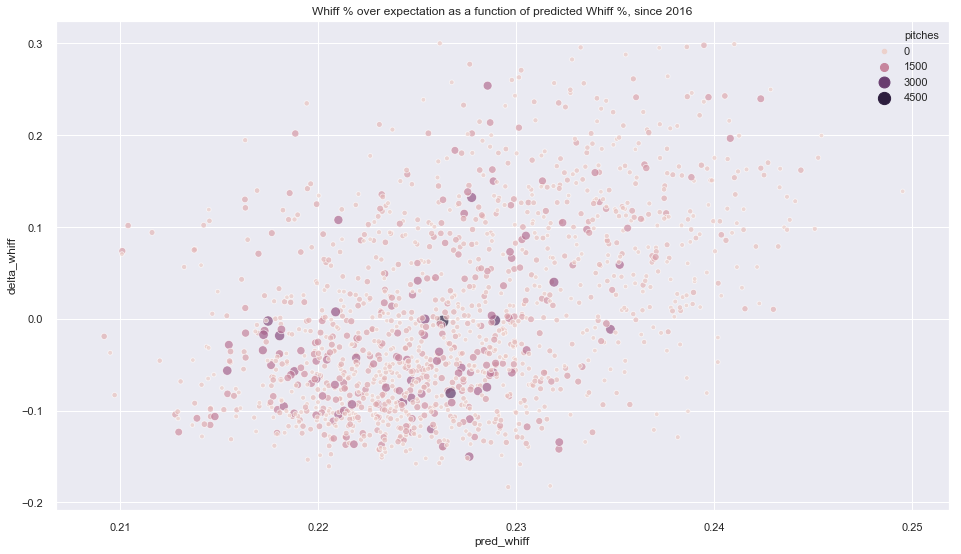

In [66]:
sns.scatterplot(
    x=df_summary_whiff_f['pred_whiff'],
    y=df_summary_whiff_f['delta_whiff'],
    hue=df_summary_whiff_f['pitches'],
    size=df_summary_whiff_f['pitches'],
    sizes=(20, 150),
    alpha=0.7
)

plt.title('Whiff % over expectation as a function of predicted Whiff %, since 2016')

Text(0.5,1,'Whiff % over expectation as a function of pitch count, since 2016')

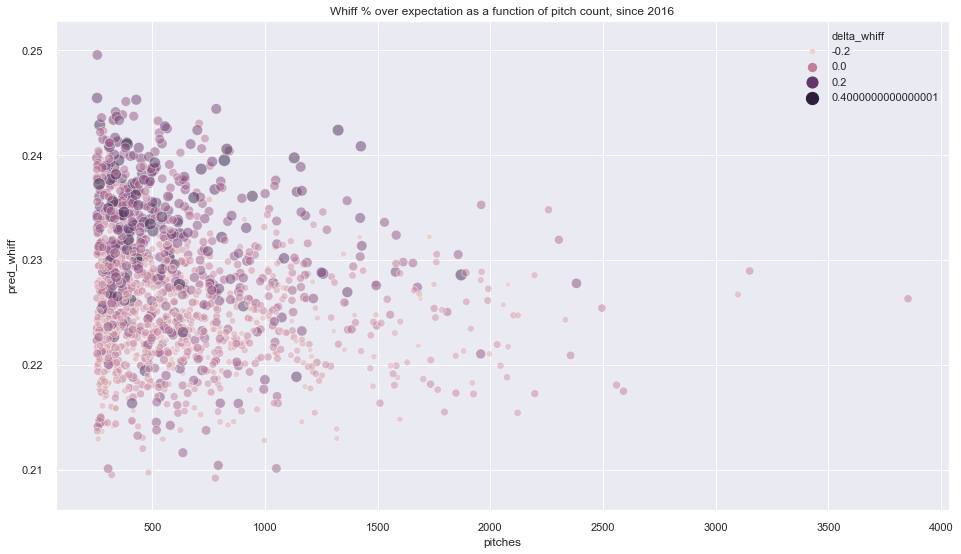

In [67]:
sns.scatterplot(
    x=df_summary_whiff_f['pitches'],
    y=df_summary_whiff_f['pred_whiff'],
    hue=df_summary_whiff_f['delta_whiff'],
    size=df_summary_whiff_f['delta_whiff'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('Whiff % over expectation as a function of pitch count, since 2016')

#### Pitches in 2019

In [57]:
df_whiff_2019 = df_whiff[df_whiff['game_year'] == 2019].groupby(['pitcher_id', 'pitcher_name', 'pitch_type']).agg({
    'event_id': 'count',
    'flag_swstr': 'mean',
    'pred_whiff': 'mean'
}).rename(columns={
    'event_id': 'pitches',
    'flag_swstr': 'whiff'
})

df_whiff_2019['delta_whiff'] = df_whiff_2019['whiff'] - df_whiff_2019['pred_whiff']

In [61]:
df_whiff_2019[df_whiff_2019['pitches'] > 50].sort_values(by=['whiff'], ascending=False).head(10)

,,,pitches,whiff,pred_whiff,delta_whiff
pitcher_id,pitcher_name,pitch_type,,,,
669203,Corbin Burnes,SL,115,0.617391,0.243125,0.374267
571704,Ken Giles,SL,93,0.602151,0.239334,0.362816
571656,Buck Farmer,SL,58,0.568966,0.247817,0.321149
622259,Trey Wingenter,SL,80,0.562500,0.235985,0.326515
623433,Nick Anderson,CU,100,0.560000,0.238519,0.321481
571760,Andrew Heaney,CU,59,0.559322,0.241433,0.317889
607237,Amir Garrett,SL,127,0.559055,0.227175,0.331880
605483,Blake Snell,CU,170,0.558824,0.223622,0.335201
669456,Shane Bieber,KC,105,0.552381,0.233158,0.319223


In [62]:
# Summary filters
_cutoff_year_whiff = df_whiff_2019['pitches'] > 50

df_whiff_2019_f = df_whiff_2019[_cutoff_year_whiff]

Text(0.5,1,'Whiff % over expectation as a function of predicted Whiff %, 2019')

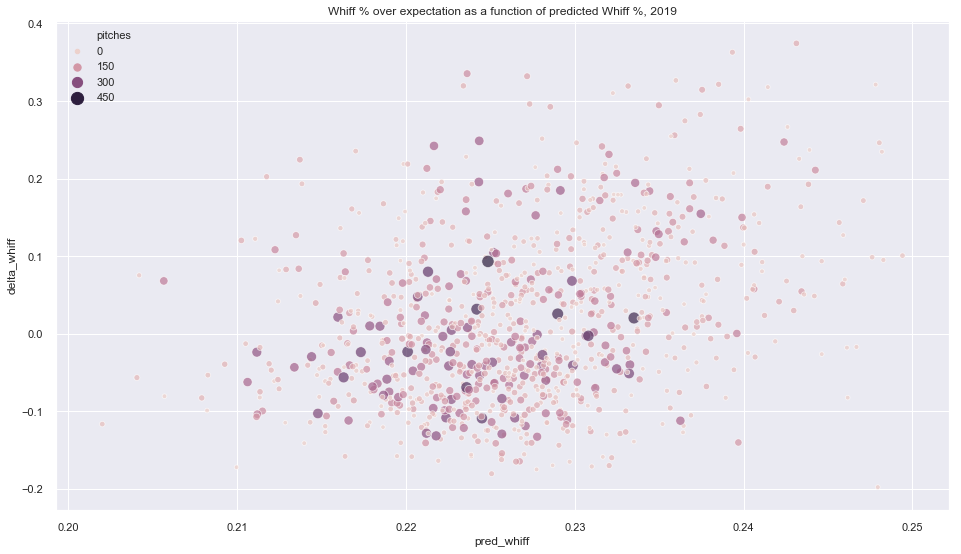

In [64]:
sns.scatterplot(
    x=df_whiff_2019_f['pred_whiff'],
    y=df_whiff_2019_f['delta_whiff'],
    hue=df_whiff_2019_f['pitches'],
    size=df_whiff_2019_f['pitches'],
    sizes=(20, 150),
    alpha=0.7
)

plt.title('Whiff % over expectation as a function of predicted Whiff %, 2019')

Text(0.5,1,'Whiff % over expectation as a function of pitch count, 2019')

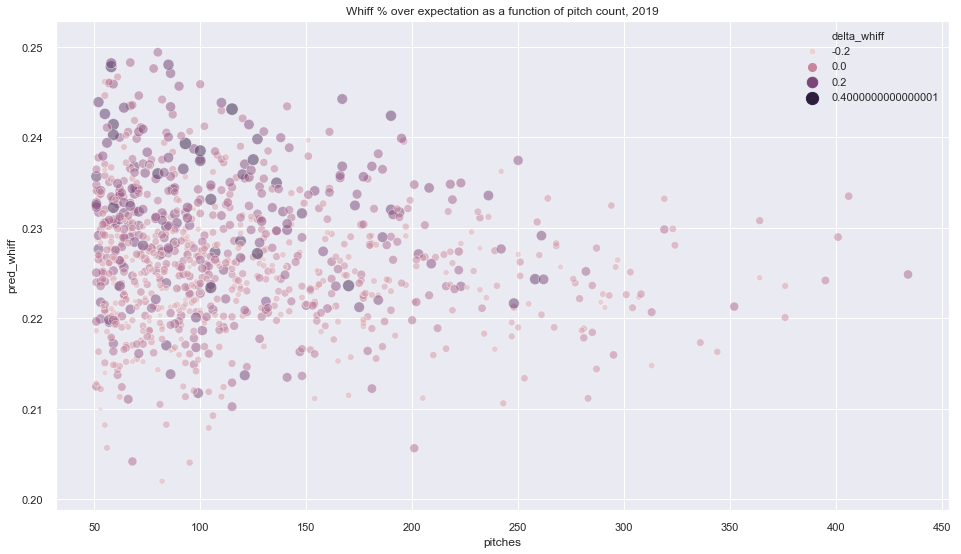

In [68]:
sns.scatterplot(
    x=df_whiff_2019_f['pitches'],
    y=df_whiff_2019_f['pred_whiff'],
    hue=df_whiff_2019_f['delta_whiff'],
    size=df_whiff_2019_f['delta_whiff'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('Whiff % over expectation as a function of pitch count, 2019')

#### Export data

In [69]:
df_whiff_2019.to_csv('~/Desktop/expected_whiff_2019.csv')
df_summary_whiff.to_csv('~/Desktop/expected_whiff_all_time.csv')